In [12]:
import os
import glob

import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from skimage.feature import hog
import matplotlib.pyplot as plt

from skimage import exposure
from skimage.color import rgb2gray
from scipy.ndimage import convolve, uniform_filter
from skimage.filters import gabor_kernel, unsharp_mask, threshold_otsu, gabor
from skimage.morphology import disk, closing, dilation
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from utils.vis import draw_bboxes
from utils.bboxes import resize_bounding_box
from utils.dataset import load_yolo_labels
from utils.preprocess import sliding_window
from utils.bboxes import iou, calculate_boxA_percentage
from utils.intensity_transforms import histogram_matching
%matplotlib inline

In [13]:
# root_path = '/content/drive/Shareddrives/Wrist_fracture_detectiom/ML/Dataset'
root_path = 'MLDataset/crop_data'

img_train_folder = 'train'
img_test_folder = 'test'
label_folder = 'labels'
image_folder = 'images'

In [14]:
selected_features = [0,1,2,4,5,7,15,19,21,26,31,36,37,38,40,44,51]

In [15]:
# Load pre-trained AlexNet model
alexnet = models.alexnet(pretrained=True)

# Define the image preprocessing transformations
preprocess = transforms.Compose([
    # transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_image(image):
    if isinstance(image, str):
        image = Image.open(image).convert('RGB')
    elif isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    image = preprocess(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

def extract_features(image):
    image = load_image(image)
    with torch.no_grad():
        features = feature_extractor(image)
    return features[0].numpy()

# Modify the model to output features from the first convolutional layer
class FeatureExtractor(nn.Module):
    def __init__(self, submodule, extracted_layer):
        super(FeatureExtractor, self).__init__()
        self.submodule = submodule
        self.extracted_layer = extracted_layer

    def forward(self, x):
        for name, module in self.submodule._modules.items():
            x = module(x)
            if name == self.extracted_layer:
                return x

# Extract features from the first convolutional layer
layer_name = '0'
feature_extractor = FeatureExtractor(alexnet.features, extracted_layer=layer_name)

/Users/huytrq/miniconda3/envs/py11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/huytrq/miniconda3/envs/py11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
feature_extractor

FeatureExtractor(
  (submodule): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

In [17]:
def visualize_features(image_path):
    image = load_image(image_path)
    with torch.no_grad():
        features = feature_extractor(image)
    
    # Convert tensor to numpy array
    feature_map = features[0].squeeze(0).cpu().numpy()
    
    # Plot feature maps
    num_feature_maps = feature_map.shape[0]
    plt.figure(figsize=(30, 30))
    for i in range(num_feature_maps):
        plt.subplot(8, 8, i + 1)
        plt.imshow(feature_map[i], cmap='gray')
        plt.title(f'Feature Map {i}')
    plt.show()


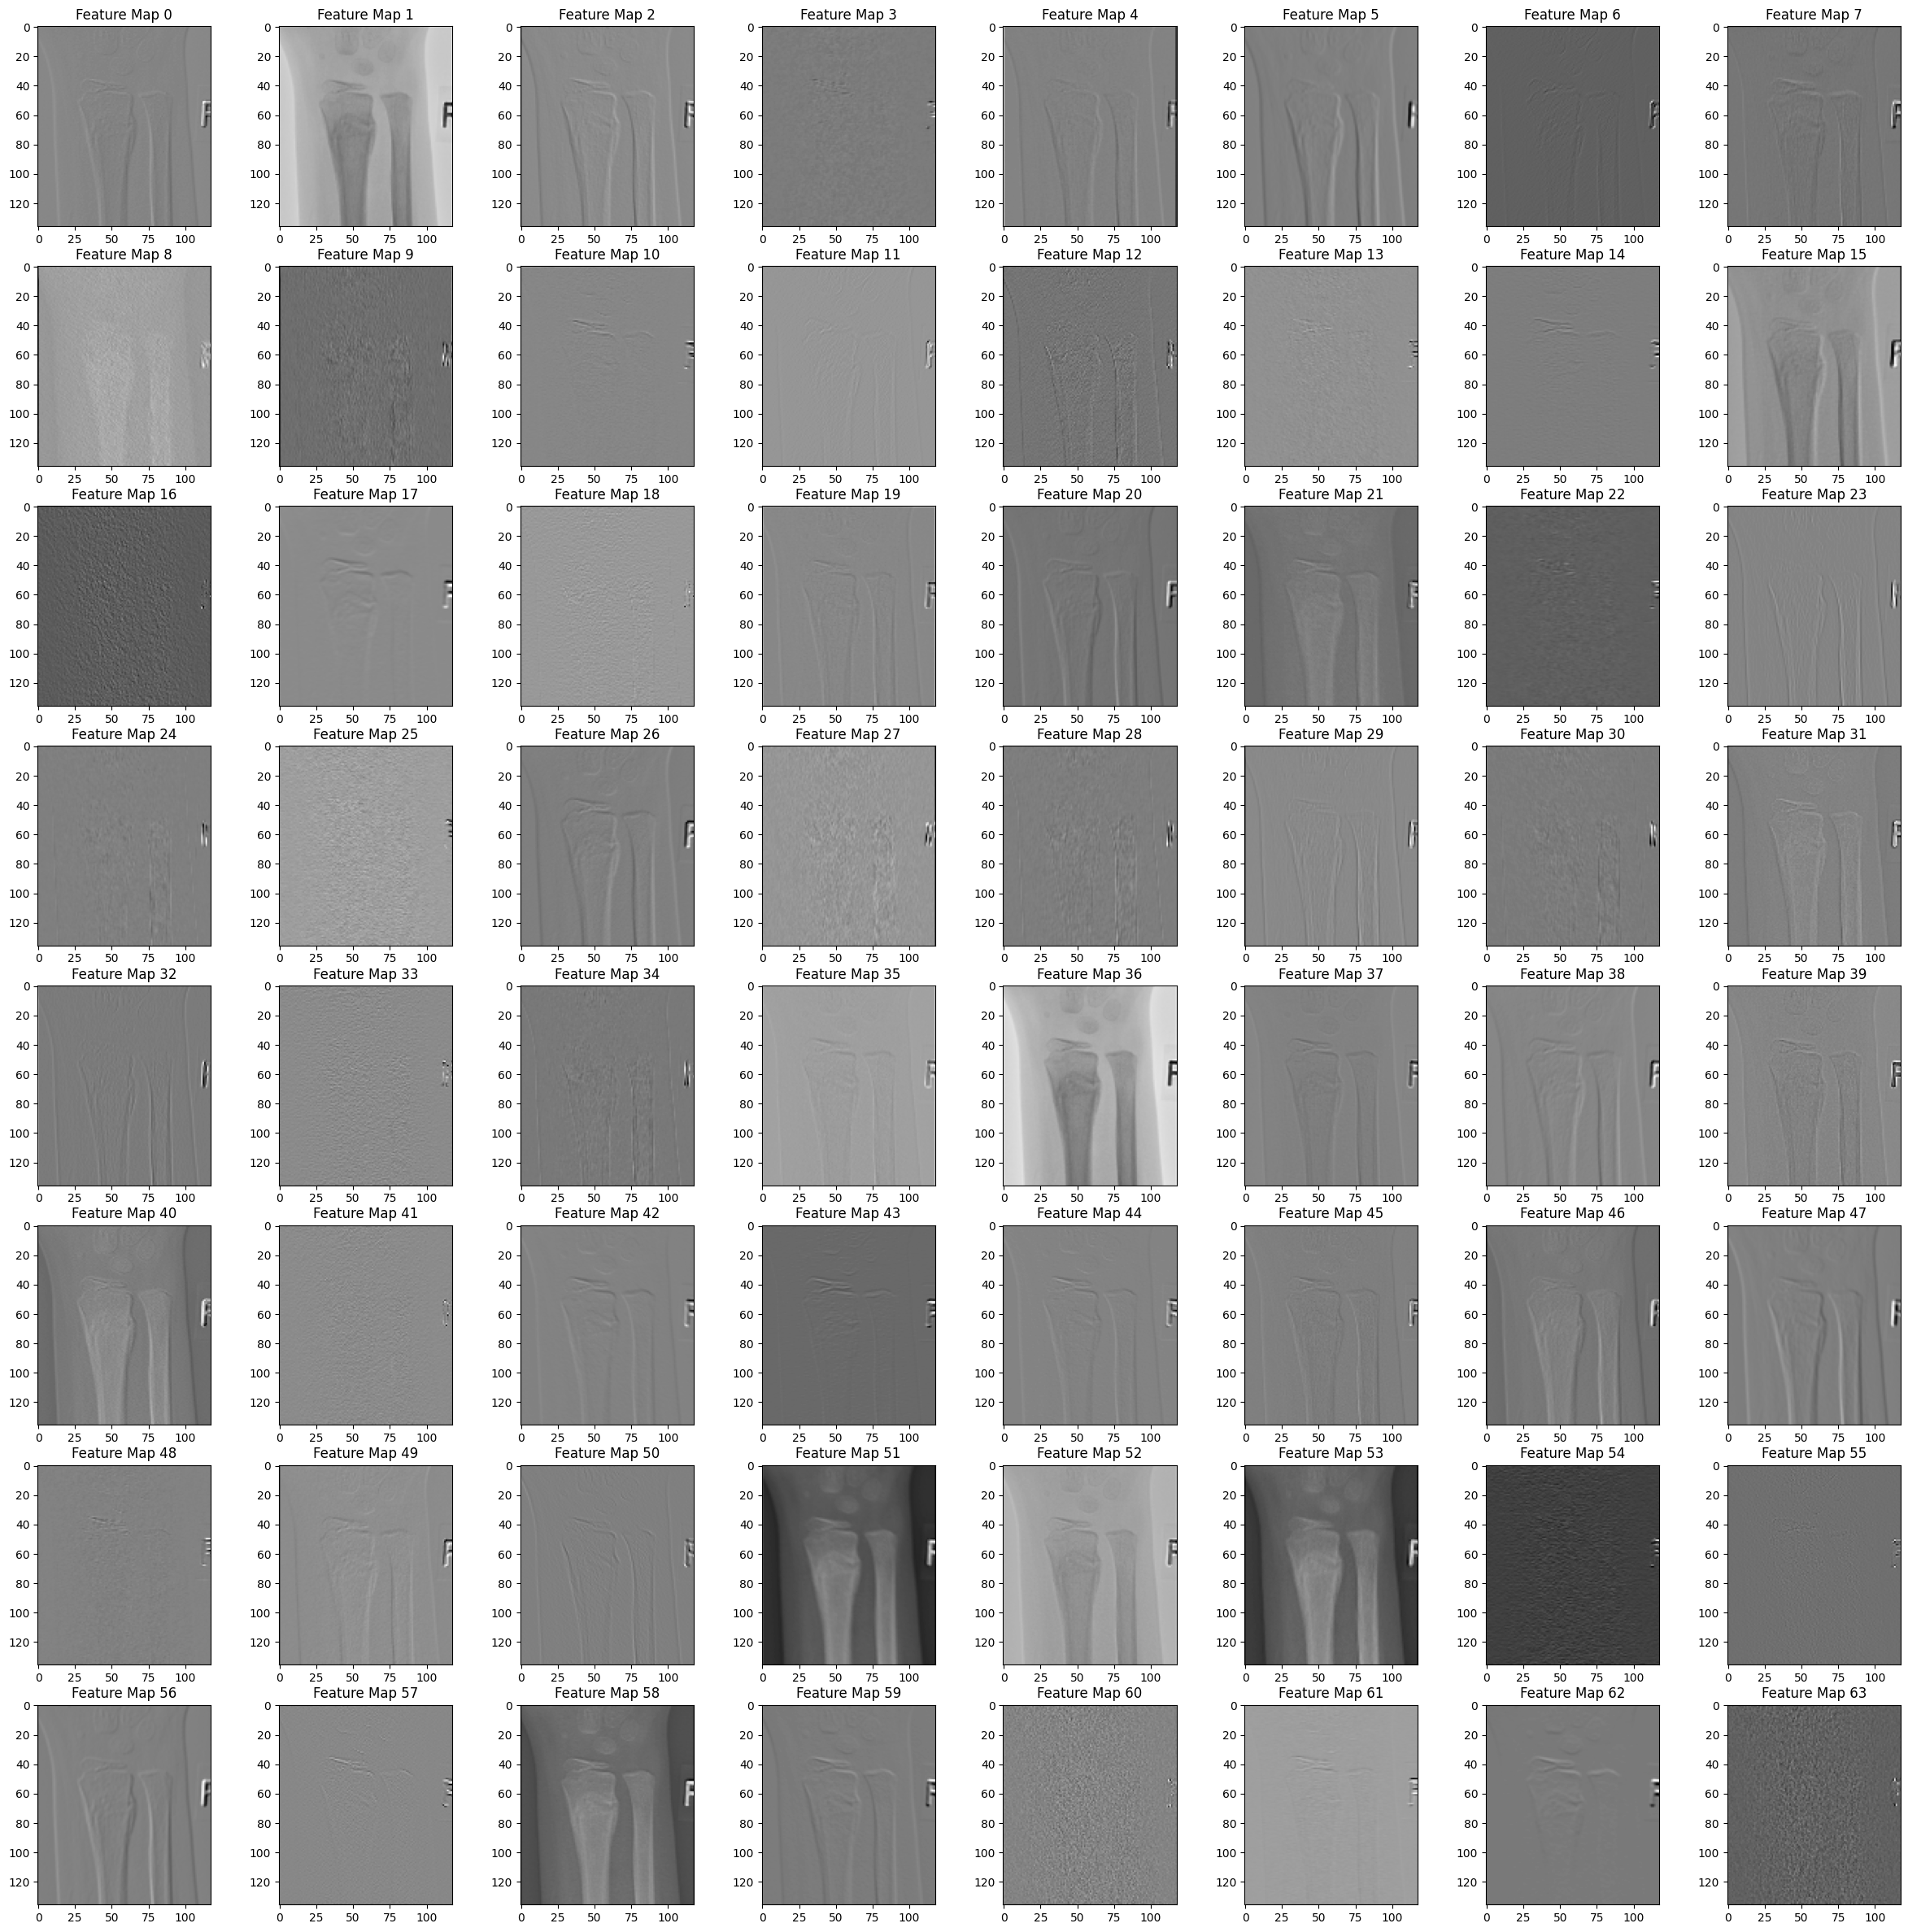

In [18]:
visualize_features('MLDataset/crop_data/images/train/fracture/0197_0794660705_06_WRI-R1_M006.png')

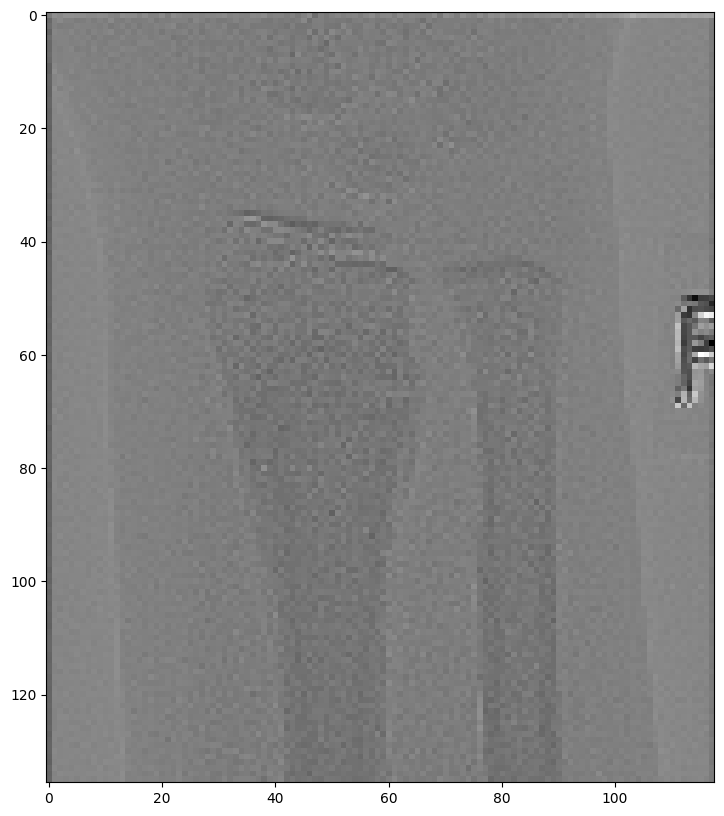

In [6]:
image = load_image('MLDataset/crop_data/images/train/fracture/0197_0794660705_06_WRI-R1_M006.png')
with torch.no_grad():
    features = feature_extractor(image)
    features = features[0].sum(axis=0)
    
plt.figure(figsize=(10, 10))
plt.imshow(features, cmap='gray')
plt.show()

In [9]:
import skimage
img = skimage.io.imread('MLDataset/crop_data/images/train/fracture/0197_0794660705_06_WRI-R1_M006.png')
img = skimage.measure.block_reduce(img, (4,4), np.max)
img.shape

(138, 119)

In [11]:
### Extract mean histogram from the training dataset
mean_histogram =np.load('mean_hist.npy')

def image_preprocess(image, mean_histogram=None, dilate_num=4, intensity_crop=1, outputbitdepth=8, unsharp=True):
    """
    Processes a single image by applying histogram matching, thresholding,
    multiple dilations, and closing.

    Args:
    - image_path (str/numpy): Path to the image file or numpy array of the image.
    - mean_histogram (array-like): The histogram to match. If None, don't match histogram.
    - dilate_num (int): Number of times dilation should be applied.
    - intensity_crop (int): Percentage of the image intensity to crop.
    - outputbitdepth (int): The bit depth of the output image.

    Returns:
    - final_image (ndarray): The processed image.
    """
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    elif isinstance(image, np.ndarray):
        if image.ndim == 3:
            image = rgb2gray(image)
    else:
        raise ValueError("Image must be a file path or numpy array.")
    
    if unsharp:
        image = ((unsharp_mask(image, radius=2, amount=1))*255).clip(0, 255).astype(np.uint8) # unsharp mask to enhance edges

    ## Histogram equalization
    image = exposure.rescale_intensity(image, in_range=(np.percentile(image, intensity_crop), np.percentile(image, (100-intensity_crop))))
    image = exposure.equalize_adapthist(image)

    
    ## Normalize image
    image = cv2.normalize(image, dst=None, alpha=0, beta=int((pow(2, outputbitdepth))-1), norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    
    # Apply histogram matching (assuming this function is defined elsewhere)
    if mean_histogram is not None:  
        image = histogram_matching(image, mean_histogram)
    
    # Apply Otsu's thresholding
    thresh = threshold_otsu(image)
    binary_mask = image > thresh
    
    # Apply multiple dilations
    selem = disk(4)
    dilated_mask = binary_mask
    for _ in range(dilate_num):
        dilated_mask = dilation(dilated_mask, selem)
    
    # Apply closing to the dilated mask
    closed_mask = closing(dilated_mask, selem)
    
    # Apply the mask to the original image using a bitwise AND operation
    final_image = cv2.bitwise_and(image, image, mask=np.uint8(closed_mask * 255))
    
    return final_image


In [46]:
windowSize = 128
stepSize = 128

Processing 0/403 : MLDataset/crop_data/images/train/fracture/1009_1044044123_01_WRI-R2_M013.png


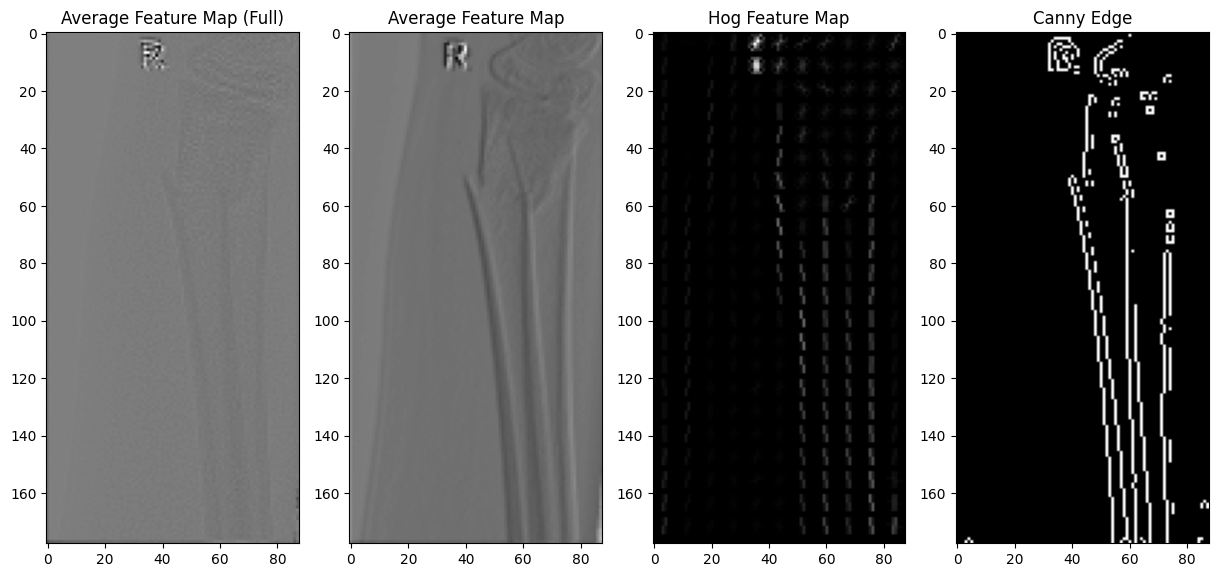

Processing 1/403 : MLDataset/crop_data/images/train/fracture/0685_0423920025_03_WRI-L2_M006.png


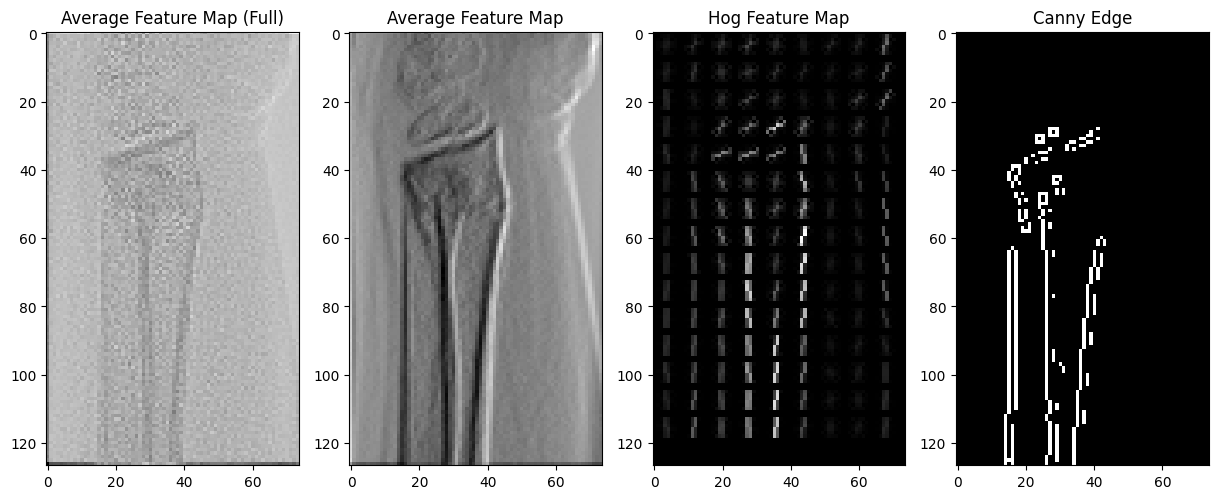

Processing 2/403 : MLDataset/crop_data/images/train/fracture/0654_0390186073_01_WRI-R1_M013.png


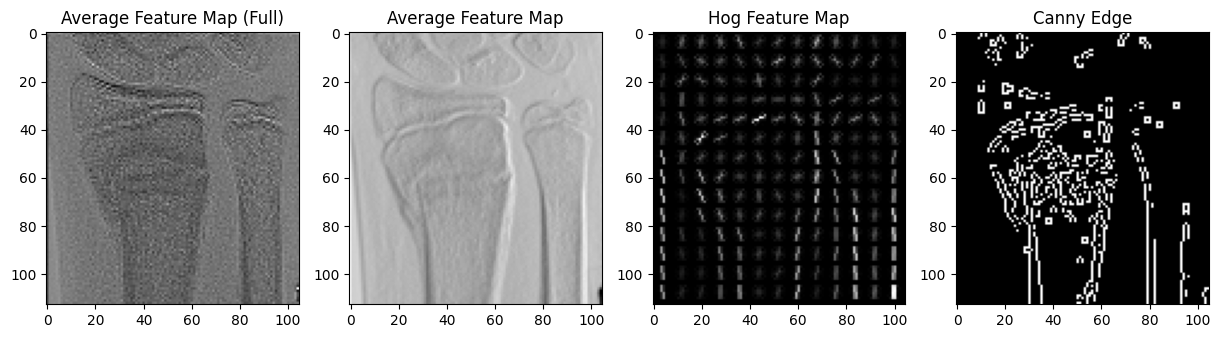

Processing 3/403 : MLDataset/crop_data/images/train/fracture/1157_1136128863_02_WRI-L2_M012.png


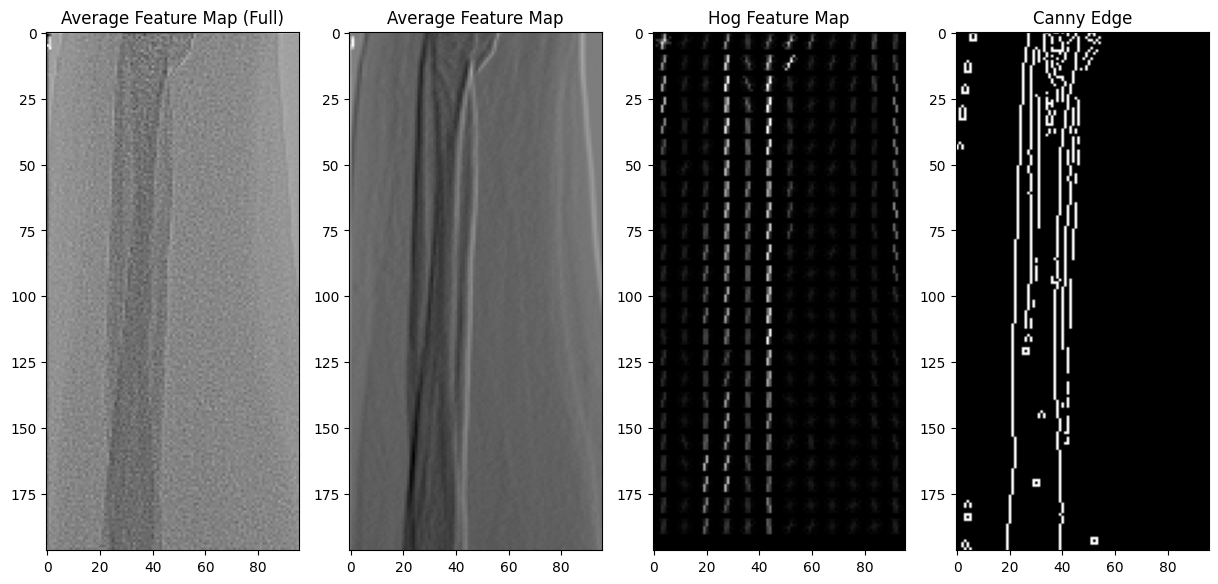

Processing 4/403 : MLDataset/crop_data/images/train/fracture/1350_1064528986_01_WRI-L1_M005.png


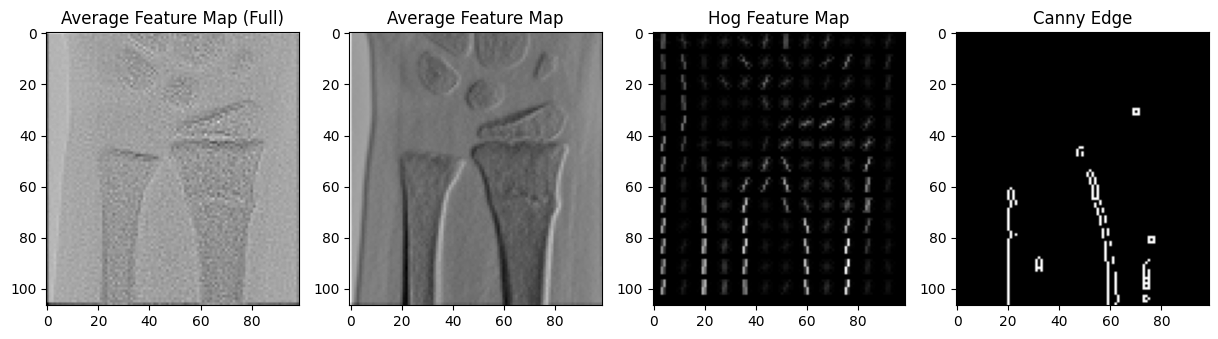

Processing 5/403 : MLDataset/crop_data/images/train/fracture/1009_1047321876_07_WRI-R1_M013.png


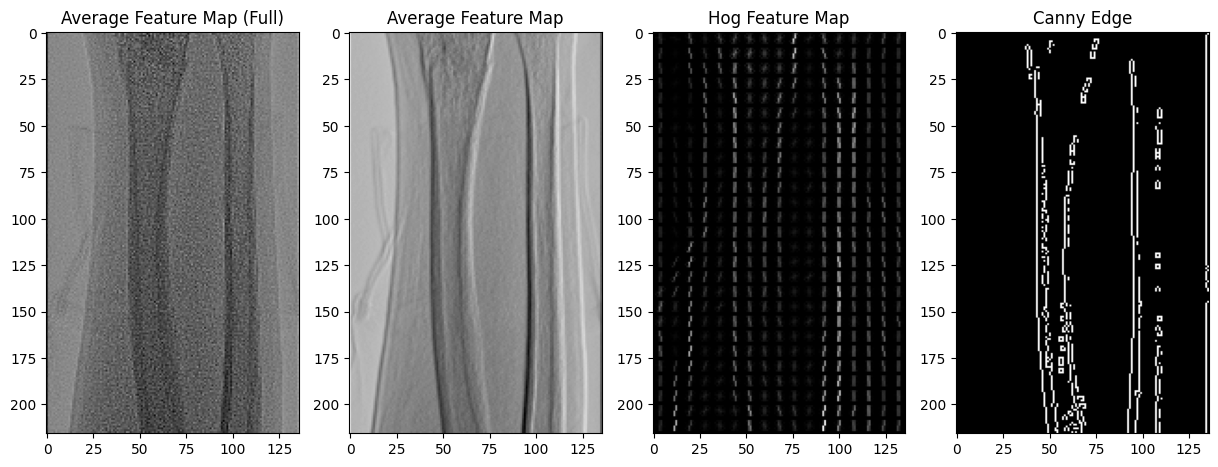

Processing 6/403 : MLDataset/crop_data/images/train/fracture/0749_0875713484_06_WRI-L1_M005.png


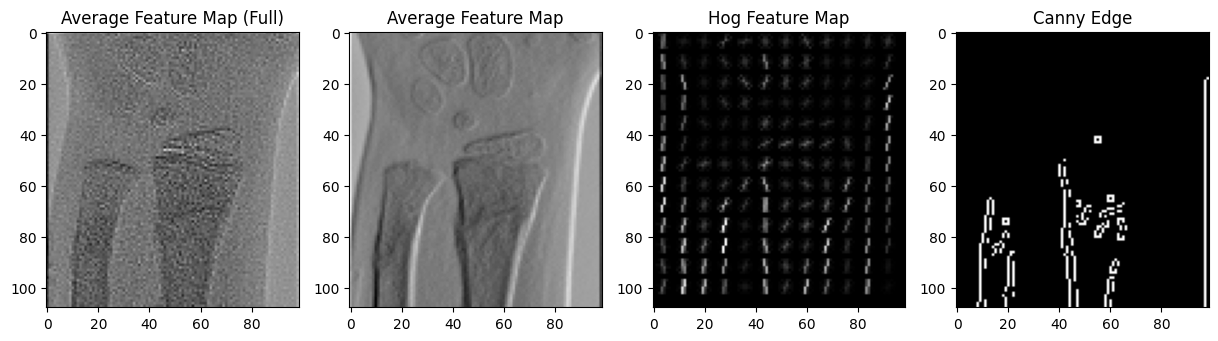

Processing 7/403 : MLDataset/crop_data/images/train/fracture/4708_0685185180_02_WRI-L3_M005.png


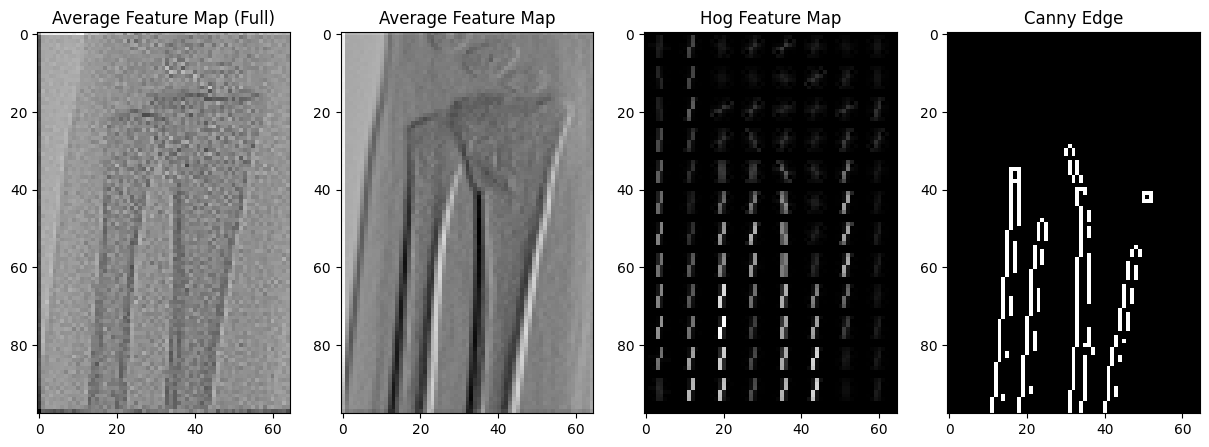

Processing 8/403 : MLDataset/crop_data/images/train/fracture/1226_0715562150_01_WRI-L2_F011.png


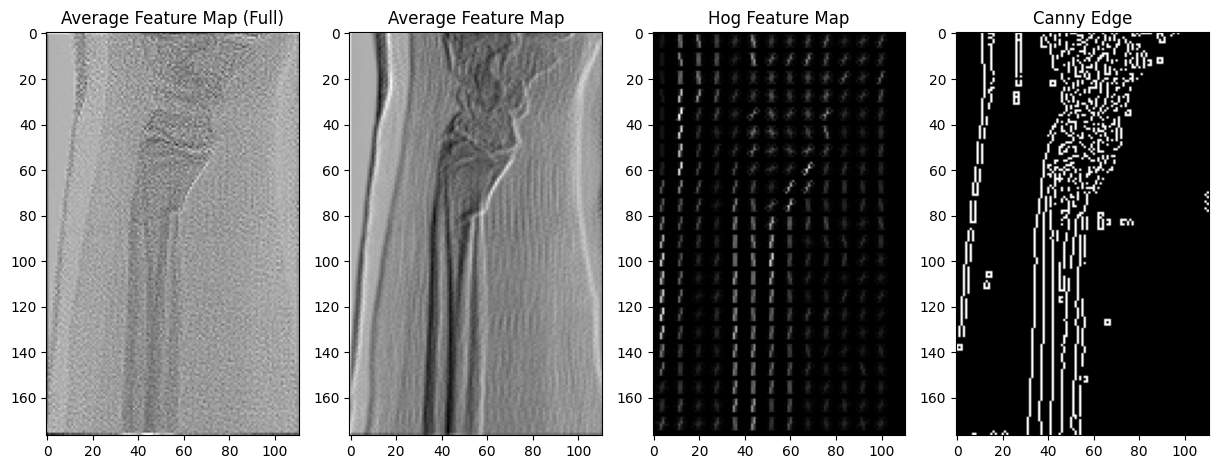

Processing 9/403 : MLDataset/crop_data/images/train/fracture/0600_0786418117_04_WRI-L2_F005.png


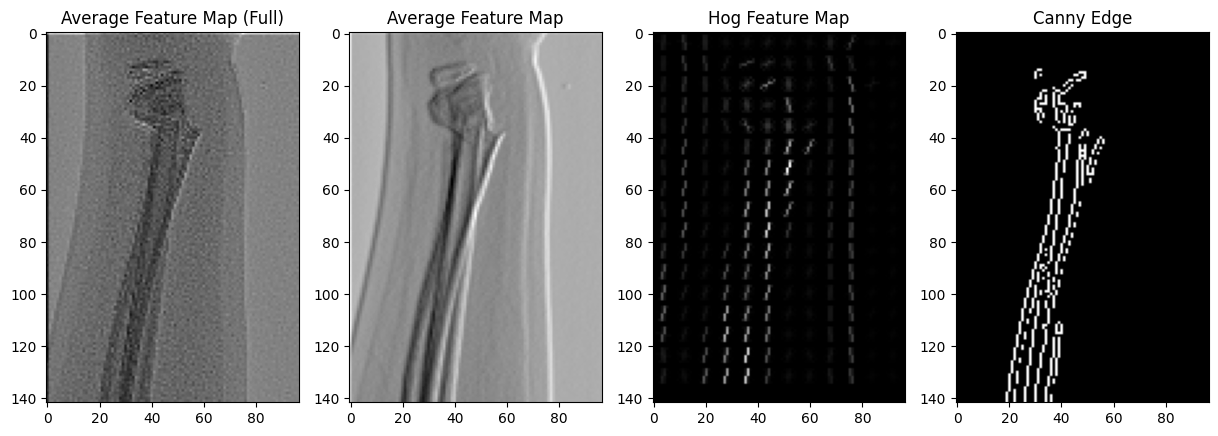

Processing 10/403 : MLDataset/crop_data/images/train/fracture/0480_1161554902_04_WRI-L1_M007.png


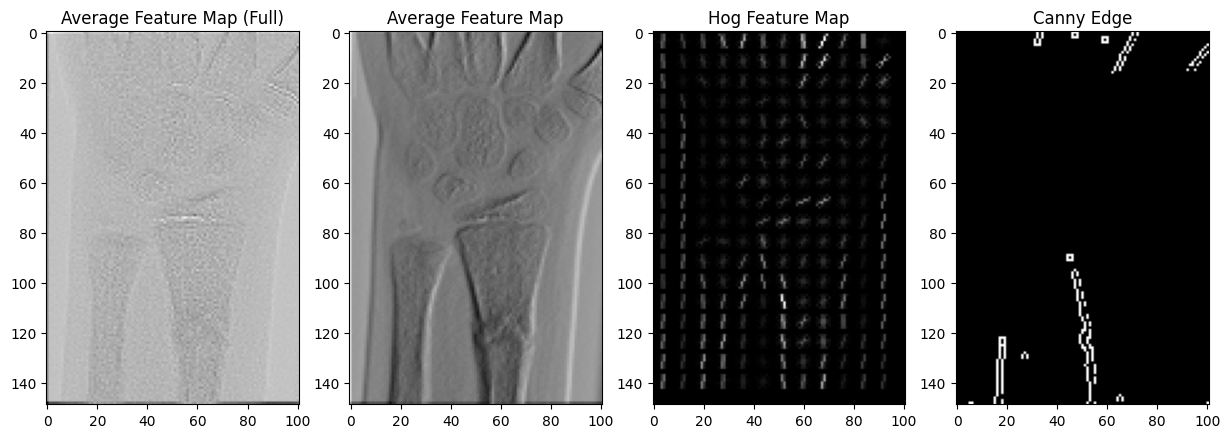

Processing 11/403 : MLDataset/crop_data/images/train/fracture/0916_0959314532_05_WRI-L2_M007.png


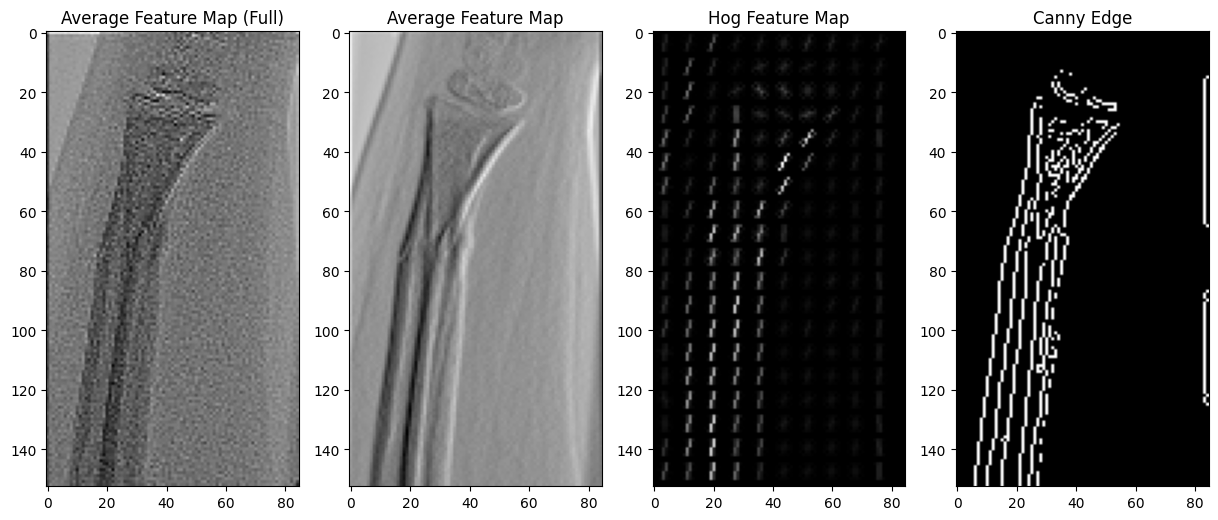

Processing 12/403 : MLDataset/crop_data/images/train/fracture/0244_1110359774_01_WRI-R1_M007.png


KeyboardInterrupt: 

In [83]:
# Example usage
modes = ['train', 'test']
class_names = ['fracture', 'normal']

for mode in modes:
    for class_name in class_names:
        features_list = []
        labels_list = []
        files = []
        image_files = glob.glob(os.path.join(root_path, image_folder, mode, class_name, '*.png'))
        ### Loop through all images
        for idx, image_path in enumerate(image_files):
            print(f"Processing {idx}/{len(image_files)} : {image_path}")
            image = cv2.imread(image_path)
            # image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
            # image = image_preprocess(image_path)
            all_features = extract_features(image)
            
            average_feature_map_full = all_features.mean(axis=0)
            average_feature_map = all_features[selected_features,].mean(axis=0)
            
            hog_f, hog_image = hog(average_feature_map, orientations=16, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
            canny = cv2.Canny(average_feature_map.astype(np.uint8), 100, 200)
            
            label_path = image_path.replace(image_folder, label_folder).replace('.png', '.txt')
            labels = []
            if os.path.exists(label_path):
                labels = load_yolo_labels(label_path, image.shape)
                # labels = [resize_bounding_box(label, image.shape[:2], average_feature_map.shape) for label in labels]

                # draw_bboxes(average_feature_map, new_labels)
                        


            plt.figure(figsize=(15, 15))
            plt.subplot(1, 4, 1)
            plt.imshow(average_feature_map_full, cmap='gray')
            plt.title('Average Feature Map (Full)')
            
            plt.subplot(1, 4, 2)
            plt.imshow(average_feature_map, cmap='gray')
            plt.title('Average Feature Map')
            
            plt.subplot(1, 4, 3)
            plt.imshow(hog_image, cmap='gray')
            plt.title('Hog Feature Map')
            
            plt.subplot(1, 4, 4)
            plt.imshow(canny, cmap='gray')
            plt.title('Canny Edge')
            
            
            plt.show()

In [ ]:
selected_features = [0,1,2,4,5,7,15,19,21,26,31,36,37,38,40,44,51]

show_grid = True
# Example usage
modes = ['train', 'test']
class_names = ['fracture', 'normal']

for mode in modes:
    for class_name in class_names:
        features_list = []
        labels_list = []
        files = []
        image_files = glob.glob(os.path.join(root_path, image_folder, mode, class_name, '*.png'))
        ### Loop through all images
        for idx, image_path in enumerate(image_files):
            print(f"Processing {idx}/{len(image_files)} : {image_path}")
            # image = cv2.imread(image_path)
            image = image_preprocess(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
            
            label_path = image_path.replace(image_folder, label_folder).replace('.png', '.txt')
            labels = []
            if os.path.exists(label_path):
                labels = load_yolo_labels(label_path, image.shape)
                # labels = [resize_bounding_box(label, image.shape[:2], average_feature_map.shape) for label in labels]

                # draw_bboxes(average_feature_map, new_labels)
                
            # Use sliding window to generate windows
            windows = list(sliding_window(image, stepSize=stepSize, windowSize=windowSize))
            num_windows = len(windows)
                
            if show_grid:
                # Determine the grid size
                grid_size = int(np.ceil(np.sqrt(num_windows)))
                fig, ax = plt.subplots(grid_size, grid_size, figsize=(20, 20))
                        
            for i, (x, y, window_f) in enumerate(sliding_window(image, stepSize=stepSize, windowSize=windowSize)):
                if window_f.shape[0] != windowSize or window_f.shape[1] != windowSize:
                    continue
                
                features = extract_features(window_f)
                features = features[selected_features, :, :]
                features = features.sum(axis=0)
                hog_f, hog_image = hog(features, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualize=True)
                
                is_fracture = False
                for label in labels:
                    c, *xyxy = label
                    iou_score = calculate_boxA_percentage(xyxy, [x, y, x + windowSize, y + windowSize])
                    if iou_score > 0.5:
                        is_fracture = True
                        break
            
                if show_grid:
                    # Plot the window
                    ax[i // grid_size, i % grid_size].imshow(hog_image, cmap='gray')
                    ax[i // grid_size, i % grid_size].title.set_text(f'{iou_score:.2}' + (' Fracture' if is_fracture else ' Non-Fracture'))
                    ax[i // grid_size, i % grid_size].axis('off')
            
                    
            if show_grid:
                # Turn off any unused subplots
                for j in range(i + 1, grid_size * grid_size):
                    ax[j // grid_size, j % grid_size].title.set_text('Unused')
                    ax[j // grid_size, j % grid_size].axis('off')
                plt.show()

In [13]:
def export_features(export_path, name, feature_name, feature_list):
    """Save features to npy file

    Args:
        export_path (str): path to save the file
        name (str): file name to save
        feature_name (str): name of the feature. Ex: 'lbp', 'hog', 'gabor'
        feature_list (list/array): list of features
    """
    ## Export features to file
    save_name = f'{name}_{feature_name}.npy'
    save_path = os.path.join(export_path, save_name)
    np.save(save_path, feature_list)
    print(f'Save {feature_name} features to {save_path}')

In [113]:
stepSize = 32
windowSize = 64

In [114]:
selected_features = [0,1,2,4,5,7,15,19,21,26,31,36,37,38,40,44,51]

# Example usage
modes = ['train', 'test']
class_names = ['fracture', 'normal']

for mode in modes:
    for class_name in class_names:
        features_list = []
        labels_list = []
        files = []
        image_files = glob.glob(os.path.join(root_path, image_folder, mode, class_name, '*.png'))
        ### Loop through all images
        for idx, image_path in enumerate(image_files):
            print(f"Processing {idx}/{len(image_files)} : {image_path}")
            # image = cv2.imread(image_path)
            image = image_preprocess(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
            
            label_path = image_path.replace(image_folder, label_folder).replace('.png', '.txt')
            labels = []
            if os.path.exists(label_path):
                labels = load_yolo_labels(label_path, image.shape)
                # labels = [resize_bounding_box(label, image.shape[:2], average_feature_map.shape) for label in labels]

                # draw_bboxes(average_feature_map, new_labels)
                        
            for i, (x, y, window_f) in enumerate(sliding_window(image, stepSize=stepSize, windowSize=windowSize)):
                if window_f.shape[0] != windowSize or window_f.shape[1] != windowSize:
                    continue
                
                features = extract_features(window_f)
                features = features[selected_features, :, :]
                features = features.sum(axis=0)
                hog_f, hog_image = hog(features, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=True)
                feature = hog_f.ravel()
                # feature = np.concatenate([f.ravel() for f in features], axis=0)
                
                iou_score = 0
                class_id = 0
                for label in labels:
                    c, *xyxy = label
                    iou_score = calculate_boxA_percentage(xyxy, [x, y, x + windowSize, y + windowSize])
                    if iou_score > 0.5:
                        class_id = 1
                    elif iou_score > 0.1 and iou_score < 0.5:
                        class_id = -1
            
                features_list.append(feature)
                labels_list.append(class_id)
                files.append(image_path)
                
        name = mode + '_' + class_name
        export_features(export_path=root_path, name=name, feature_name='alexnet', feature_list=features_list)
        export_features(export_path=root_path, name=name, feature_name='labels_alexnet', feature_list=labels_list)
        export_features(export_path=root_path, name=name, feature_name='files_alexnet', feature_list=files)

Processing 0/403 : MLDataset/crop_data/images/train/fracture/1009_1044044123_01_WRI-R2_M013.png
Processing 1/403 : MLDataset/crop_data/images/train/fracture/0685_0423920025_03_WRI-L2_M006.png
Processing 2/403 : MLDataset/crop_data/images/train/fracture/0654_0390186073_01_WRI-R1_M013.png
Processing 3/403 : MLDataset/crop_data/images/train/fracture/1157_1136128863_02_WRI-L2_M012.png
Processing 4/403 : MLDataset/crop_data/images/train/fracture/1350_1064528986_01_WRI-L1_M005.png
Processing 5/403 : MLDataset/crop_data/images/train/fracture/1009_1047321876_07_WRI-R1_M013.png
Processing 6/403 : MLDataset/crop_data/images/train/fracture/0749_0875713484_06_WRI-L1_M005.png
Processing 7/403 : MLDataset/crop_data/images/train/fracture/4708_0685185180_02_WRI-L3_M005.png
Processing 8/403 : MLDataset/crop_data/images/train/fracture/1226_0715562150_01_WRI-L2_F011.png
Processing 9/403 : MLDataset/crop_data/images/train/fracture/0600_0786418117_04_WRI-L2_F005.png
Processing 10/403 : MLDataset/crop_data/

In [115]:
feature_list = ['alexnet']

train_features_list = []
train_labels = None
test_features_list = []
test_labels = None

for feature_name in feature_list:
    # Load the dictionary from the .npz file
    train_fracture = np.load(os.path.join(root_path, f'train_fracture_{feature_name}.npy'), allow_pickle=True)
    train_normal = np.load(os.path.join(root_path, f'train_normal_{feature_name}.npy'), allow_pickle=True)
    train_fracture_labels = np.load(os.path.join(root_path, f'train_fracture_labels_{feature_name}.npy'), allow_pickle=True)
    train_normal_labels = np.load(os.path.join(root_path, f'train_normal_labels_{feature_name}.npy'), allow_pickle=True)
    train_fracture_files = np.load(os.path.join(root_path, f'train_fracture_files_{feature_name}.npy'), allow_pickle=True)
    train_normal_files = np.load(os.path.join(root_path, f'train_normal_files_{feature_name}.npy'), allow_pickle=True)

    test_fracture = np.load(os.path.join(root_path, f'test_fracture_{feature_name}.npy'), allow_pickle=True)
    test_normal = np.load(os.path.join(root_path, f'test_normal_{feature_name}.npy'), allow_pickle=True)
    test_fracture_labels = np.load(os.path.join(root_path, f'test_fracture_labels_{feature_name}.npy'), allow_pickle=True)
    test_normal_labels = np.load(os.path.join(root_path, f'test_normal_labels_{feature_name}.npy'), allow_pickle=True)
    test_fracture_files = np.load(os.path.join(root_path, f'test_fracture_files_{feature_name}.npy'), allow_pickle=True)
    test_normal_files = np.load(os.path.join(root_path, f'test_normal_files_{feature_name}.npy'), allow_pickle=True)

    train_files = np.concatenate([train_fracture_files, train_normal_files])
    train_features = np.concatenate([train_fracture, train_normal])
    train_labels= np.concatenate([train_fracture_labels, train_normal_labels])
    train_indices = np.where(train_labels!= -1)[0]
    train_features = train_features[train_indices]
    train_labels= train_labels[train_indices]

    test_files = np.concatenate([test_fracture_files, test_normal_files])
    test_features= np.concatenate([test_fracture, test_normal])
    test_labels = np.concatenate([test_fracture_labels, test_normal_labels])
    test_indices = np.where(test_labels!= -1)[0]
    test_features = test_features[test_indices]
    test_labels = test_labels[test_indices]
    
    # Append to the list
    train_features_list.append(train_features)
    test_features_list.append(test_features)

# Concatenate the features
train_features = np.concatenate(train_features_list, axis=1)
test_features = np.concatenate(test_features_list, axis=1)

In [116]:
np.unique(train_labels, return_counts=True), np.unique(test_labels, return_counts=True)

((array([0, 1]), array([151293,    400])),
 (array([0, 1]), array([46650,    62])))

In [90]:
import math

for i in range(len(train_labels)):
    if train_labels[i] != 1:
        continue
    print(train_files[i])
    size = int(math.sqrt(train_features.shape[1]))
    plt.imshow(train_features[i].reshape(size, size), cmap='gray')
    plt.show()

MLDataset/crop_data/images/train/fracture/0654_0390186073_01_WRI-R1_M013.png


ValueError: cannot reshape array of size 1152 into shape (33,33)

In [97]:
import random
random.shuffle(list(range(len(train_features))))

In [104]:
# Split the dataset into majority and minority classes
X_majority = train_features[train_labels == 0]
y_majority = train_labels[train_labels == 0]
X_minority = train_features[train_labels == 1]
y_minority = train_labels[train_labels == 1]

# Downsample the majority class
X_majority_downsampled, y_majority_downsampled = resample(X_majority,
                                                        y_majority,
                                                        replace=False,
                                                        n_samples=len(y_minority),
                                                        random_state=42)

# Combine the downsampled majority class with the minority class
X_balanced = np.vstack((X_majority_downsampled, X_minority))
y_balanced = np.hstack((y_majority_downsampled, y_minority))

In [100]:
X_balanced = train_features
y_balanced = train_labels

In [105]:
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

In [23]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
test_features = scaler.transform(test_features)

In [106]:
model = XGBClassifier(n_estimators=100, learning_rate=0.05, num_class=2, objective='multi:softmax')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=2,
              num_parallel_tree=None, ...)

In [107]:
# Evaluate the model on the valid set
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print('f1-score:', f1_score(y_val, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70        88
           1       0.69      0.75      0.72        87

    accuracy                           0.71       175
   macro avg       0.71      0.71      0.71       175
weighted avg       0.71      0.71      0.71       175

[[59 29]
 [22 65]]
f1-score: 0.7081712847288708


In [108]:
y_true = test_labels
y_pred = model.predict(test_features)
# probs = model.predict_proba(test_features)
# y_pred[probs[:,1] < 0.6] = 0

# Evaluate the model on the valid set
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))
print('f1-score:', f1_score(y_true, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.99      0.62      0.76      3791
           1       0.05      0.77      0.09        99

    accuracy                           0.62      3890
   macro avg       0.52      0.69      0.43      3890
weighted avg       0.97      0.62      0.74      3890

[[2346 1445]
 [  23   76]]
f1-score: 0.7446913312337476
